In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import nengo

# Math

The impulse equation for the Gammatone filter is

$$g(t) = \frac{a t^{n - 1} \cos (2 \pi f_c t \phi)}{e^{2 \pi b t}}$$

where

* $a$ is a gain factor
* $n$ is the order of the filter
* $f_c$ is the characteristic frequency
* $\phi$ is the phase (ignored from this point onward -- has little effect one the filter)
* $b$ is the bandwidth (recommended setting: 1.019 times the ERB)

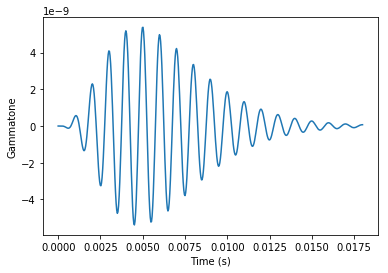

In [30]:
# Impulse response for a cochlear channel
t = np.linspace(0, 0.018, 500)
n = 4  # order of 4
b = 100  # bandwidth of 125Hz
fc = 1000  # centered at 1000Hz
plt.plot(t, t ** (n-1) * np.exp(-2 * np.pi * b * t) * np.cos(2 * np.pi * fc * t))
plt.ylabel("Gammatone")
plt.xlabel("Time (s)")

In [ ]:
# Gold standard I'm using: Brian's implementation
from brian import *
from brian.hears import *
import matplotlib.pyplot as plt

sound = whitenoise(100*ms).ramp()
sound.level = 50*dB

nbr_center_frequencies = 40
b1 = 1.019  #factor determining the time constant of the filters
#center frequencies with a spacing following an ERB scale
center_frequencies = erbspace(80*Hz, 1000*Hz, nbr_center_frequencies)
gammatone = Gammatone(sound, center_frequencies, b=b1)

gt_mon = gammatone.process()

plt.plot(sound)
plt.figure()

plt.imshow(gt_mon.T, aspect='auto', origin='lower left',
       extent=(0, sound.duration/ms,
               center_frequencies[0], center_frequencies[-1]))
plt.yscale('log')
plt.title('Cochleogram')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')

In [ ]:
def erbspace(low, high, n_samples, ear_q=9.26449, min_bw=24.7, order=1):
    """Returns the centre frequencies on an ERB scale.
    
    ``low``, ``high``
        Lower and upper frequencies
    ``N``
        Number of channels
    ``earQ=9.26449``, ``minBW=24.7``, ``order=1``
        Default Glasberg and Moore parameters.
    """
    low = float(low)
    high = float(high)
    qbw = ear_q * min_bw
    cf = (-qbw + np.exp(np.arange(n_samples)
                        * (-np.log(high + qbw) + np.log(low + qbw))
                        / (n_samples - 1))
          * (high + qbw))
    cf = cf[::-1]
    return cf

sound = np.array(sound)

In [ ]:
from scipy.signal import lfilter

def gammatone_coeffs(freq, sample_rate, b=1.019, ear_q=9.26449, min_bw=24.7, erb_order=1.):
    """Computes the filter coefficients for a bank of Gammatone filters.

    These filters were defined by Patterson and Holdworth for simulating
    the cochlea. The results are returned as arrays of filter
    coefficients. Each row of the filter arrays (forward and feedback)
    can be passed to the MatLab "filter" function, or you can do all
    the filtering at once with the ERBFilterBank() function.

    The filter bank contains "numChannels" channels that extend from
    half the sampling rate (fs) to "lowFreq".
    
    The default parameters are from Glasberg & Moore.
    The implementation is from Apple TR #35, 'An Efficient Implementation
    of the Patterson-Holdsworth Cochlear Filter Bank.'
    """
    freq = np.atleast_1d(freq)
    n_freqs = freq.size
    dt = 1. / sample_rate
    erb = ((freq / ear_q) ** erb_order + min_bw ** erb_order) ** (1. / erb_order)
    bandwidth =  2 * b * np.pi * erb

    # Cache the results of computing parts of the below computations
    fp = freq * np.pi * dt
    bw = bandwidth * dt
    ebt = {1: np.exp(bw),
           2: np.exp(2 * bw),
           3: np.exp(3 * bw),
           4: np.exp(4 * bw),
           5: np.exp(5 * bw),
           6: np.exp(6 * bw),
           7: np.exp(7 * bw),
           -8: np.exp(-8 * bw)}
    e4jfp = np.exp(4j * fp)
    g = -2 * e4jfp * dt + 2 * np.exp(-bw + 2j * fp) * dt
    cosf = {2: np.cos(2 * fp),
             4: np.cos(4 * fp),
             6: np.cos(6 * fp),
             8: np.cos(8 * fp)}
    sinf = {2: np.sin(2 * fp)}
    z_pos = np.sqrt(3 + 2 ** 1.5)
    z_neg = np.sqrt(3 - 2 ** 1.5)
    g1 = g * (cosf[2] - z_neg * sinf[2])
    g2 = g * (cosf[2] + z_neg * sinf[2])
    g3 = g * (cosf[2] - z_pos * sinf[2])
    g4 = g * (cosf[2] + z_pos * sinf[2])

    gain = np.abs(g1 * g2 * g3 * g4
                  / (-2 / ebt[2] - 2 * e4jfp + 2 * (1 + e4jfp) / ebt[1])
                  ** 4)

    forward = np.zeros((freq.size, 5))
    fwgain = dt ** 4 / gain
    forward[:, 0] = fwgain
    forward[:, 1] = fwgain * -4 * cosf[2] / ebt[1]
    forward[:, 2] = fwgain *  6 * cosf[4] / ebt[2]
    forward[:, 3] = fwgain * -4 * cosf[6] / ebt[3]
    forward[:, 4] = fwgain *      cosf[8] / ebt[4]
    
    feedback = np.zeros((freq.size, 9))
    fb1 = -8 * cosf[2]
    fb26 = 4 * (4 +  3 * cosf[4])
    fb35 = -8 * (6 * cosf[2] + cosf[6])
    fb4 = 2 * (18 + 16 * cosf[4] + cosf[8])
    fb7 = -8 * cosf[2]
    feedback[:, 0] = np.ones((freq.size,))
    feedback[:, 1] = fb1  / ebt[1]
    feedback[:, 2] = fb26 / ebt[2]
    feedback[:, 3] = fb35 / ebt[3]
    feedback[:, 4] = fb4  / ebt[4]
    feedback[:, 5] = fb35 / ebt[5]
    feedback[:, 6] = fb26 / ebt[6]
    feedback[:, 7] = fb7  / ebt[7]
    feedback[:, 8] = ebt[-8]

    return forward, feedback


def lfilter_tdf2(b, a, x):
    b = b.copy()
    a = a.copy()
    x = x.copy()
    filter_order = max(b.size, a.size)

    if a[0] != 1.0:
        a /= a[0]
        b /= b[0]

    b.resize(filter_order)
    a.resize(filter_order)

    zi = np.zeros(filter_order)
    y = np.zeros(x.size)

    for i in xrange(x.size):
        for order in xrange(min(i, filter_order - 1), 0, -1):
            zi[order - 1] = b[order] * x[i - order] - a[order] * y[i - order] + zi[order]
        y[i] = b[0] * x[i] + zi[0]
    zi.resize(filter_order - 1)
    return y


def lfilter_df1(b, a, x):
    b = b.copy()
    a = a.copy()
    x = x.copy()

    if a[0] != 1.0:
        a /= a[0]
        b /= b[0]

    y = np.zeros(x.size)
    
    for i in xrange(x.size):
        for j in xrange(min(i, b.size)):
            y[i] += b[j] * x[i - j]
        for j in xrange(1, min(i, a.size)):
            y[i] -= a[j] * y[i - j]
    return y


def gammatone(x, forward, feedback, f_func):
    rows, cols = feedback.shape
    y = np.zeros((rows, x.size))
    for i in xrange(rows):
        y[i, :] = f_func(forward[i], feedback[i], x)
    return y

In [ ]:
fs = 44100.
dt = 1. / fs
cf = erbspace(165, 1000, 40)
fw, fb = gammatone_coeffs(cf, fs)
gt = gammatone(sound.ravel(), fw, fb, lfilter_df1)
#gt = gammatone(sound.ravel(), fw, fb, lfilter_tdf2)

plt.plot(sound)
plt.figure()
plt.imshow(gt, aspect='auto', origin='lower left',
           extent=(0, sound.size/fs, cf[0], cf[-1]))
plt.yscale('log')
plt.title('Cochleogram')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')

In [ ]:
import collections
import functools


class Gammatone(nengo.synapses.LinearFilter):
    def __init__(self, freq, b=1.019, ear_q=9.26449, min_bw=24.7, erb_order=1.):
        self.freq = freq
        self.b = b
        self.ear_q = ear_q
        self.min_bw = min_bw
        self.erb_order = erb_order

    def __repr__(self):
        return "%s(%s)" % (self.__class__.__name__, self.freq)

    @property
    def size_out(self):
        return self.freq.size
    
    def make_step(self, dt, output):
        freq = np.atleast_1d(self.freq)
        erb = (((freq / self.ear_q) ** self.erb_order + self.min_bw ** self.erb_order)
               ** (1. / self.erb_order))
        bandwidth =  2 * self.b * np.pi * erb

        # Cache the results of computing parts of the below computations
        fp = freq * np.pi * dt
        bw = bandwidth * dt
        ebt = {1: np.exp(bw),
               2: np.exp(2 * bw),
               3: np.exp(3 * bw),
               4: np.exp(4 * bw),
               5: np.exp(5 * bw),
               6: np.exp(6 * bw),
               7: np.exp(7 * bw),
               -8: np.exp(-8 * bw)}
        e4jfp = np.exp(4j * fp)
        g = -2 * e4jfp * dt + 2 * np.exp(-bw + 2j * fp) * dt
        cosf = {2: np.cos(2 * fp),
                4: np.cos(4 * fp),
                6: np.cos(6 * fp),
                8: np.cos(8 * fp)}
        sinf = {2: np.sin(2 * fp)}
        z_pos = np.sqrt(3 + 2 ** 1.5)
        z_neg = np.sqrt(3 - 2 ** 1.5)
        g1 = g * (cosf[2] - z_neg * sinf[2])
        g2 = g * (cosf[2] + z_neg * sinf[2])
        g3 = g * (cosf[2] - z_pos * sinf[2])
        g4 = g * (cosf[2] + z_pos * sinf[2])

        gain = np.abs(g1 * g2 * g3 * g4
                      / (-2 / ebt[2] - 2 * e4jfp + 2 * (1 + e4jfp) / ebt[1])
                      ** 4)

        if freq.size > 1:
            num = np.zeros((5, freq.size))
            den = np.zeros((8, freq.size))
        else:
            num = np.zeros(5)
            den = np.zeros(8)

        numgain = dt ** 4 / gain
        num[0] = numgain
        num[1] = numgain * -4 * cosf[2] / ebt[1]
        num[2] = numgain *  6 * cosf[4] / ebt[2]
        num[3] = numgain * -4 * cosf[6] / ebt[3]
        num[4] = numgain *      cosf[8] / ebt[4]

        den1 = -8 * cosf[2]
        den26 = 4 * (4 +  3 * cosf[4])
        den35 = -8 * (6 * cosf[2] + cosf[6])
        den4 = 2 * (18 + 16 * cosf[4] + cosf[8])
        den7 = -8 * cosf[2]
        # Remove the initial np.ones because of how we do filtering
        den[0] = den1  / ebt[1]
        den[1] = den26 / ebt[2]
        den[2] = den35 / ebt[3]
        den[3] = den4  / ebt[4]
        den[4] = den35 / ebt[5]
        den[5] = den26 / ebt[6]
        den[6] = den7  / ebt[7]
        den[7] = ebt[-8]

        x = collections.deque(maxlen=num.shape[0])
        y = collections.deque(maxlen=den.shape[0])
        
        return functools.partial(self.general_step,
                                 output=output, x=x, y=y, num=num, den=den)

In [ ]:
from nengo.utils.compat import is_number
def filt(signal, synapse, dt, axis=0, x0=None, copy=True):
    if is_number(synapse):
        synapse = Lowpass(synapse)

    if hasattr(synapse, 'size_out'):
        filtered = np.tile(signal, (synapse.size_out, 1))
        axis = 1
    else:
        filtered = np.array(signal, copy=copy)
    filt_view = np.rollaxis(filtered, axis=axis)  # rolled view on filtered

    # --- buffer method
    if x0 is not None:
        if x0.shape != filt_view[0].shape:
            raise ValueError("'x0' with shape %s must have shape %s" %
                             (x0.shape, filt_view[0].shape))
        signal_out = np.array(x0)
    else:
        # signal_out is our buffer for the current filter state
        signal_out = np.zeros_like(filt_view[0])

    step = synapse.make_step(dt, signal_out)

    for i, signal_in in enumerate(filt_view):
        step(signal_in)
        filt_view[i] = signal_out

    return filtered

In [ ]:
fs = 44100.
dt = 1. / fs
cf = erbspace(165, 1000, 40)
gt = np.zeros((cf.size, sound.size))
syn = Gammatone(cf)
gt = filt(sound.ravel(), syn, dt)

plt.plot(sound)
plt.figure()
plt.imshow(gt, aspect='auto', origin='lower left',
           extent=(0, sound.size/fs, cf[0], cf[-1]))
plt.yscale('log')
plt.title('Cochleogram')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')

In [ ]:
# Simple Nengo model that does the filtering during a sim
fs = 44100.
dt = 1. / fs
cf = erbspace(165, 1000, 40)
gt = np.zeros((cf.size, sound.size))

hack = True

with nengo.Network() as net:
    audio = nengo.Node(output=lambda t: sound.ravel()[int(t / dt) % sound.size])
    gt = nengo.Node(size_in=cf.size)
    gt_p = nengo.Probe(gt, synapse=None)

    # Would be nice, but can't do in Nengo now...
    # nengo.Connection(audio, gt, synapse=Gammatone(cf))
    if hack:
        # Works, but is a hack        
        def wrap_gt(dt, freq, *args, **kwargs):
            output = np.zeros(freq.size)
            step = Gammatone(freq, *args, **kwargs).make_step(dt, output=output)
            def wrapped(sig):
                step(sig)
                return output
            return wrapped
        nengo.Connection(audio, gt, function=wrap_gt(dt, cf), synapse=None)
    else:
        # Works, but is slow
        for i, freq in enumerate(cf):
            nengo.Connection(audio, gt[i], synapse=Gammatone(freq))

sim = nengo.Simulator(net, dt=dt)
sim.run(0.1)


plt.plot(sound)
plt.figure()
plt.imshow(sim.data[gt_p].T, aspect='auto', origin='lower left',
           extent=(0, sound.size/fs, cf[0], cf[-1]))
plt.yscale('log')
plt.title('Cochleogram')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')